In [1]:
# ! pip install --upgrade pip
# ! pip install --upgrade git+https://github.com/oda-hub/oda_api@request-list pandas
# ! pip install linked-data-latex


import oda_api.api
import oda_api.token
import oda_api.plot_tools
import requests
import logging
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np
from ddpaper.draftdata import DraftData

# https://gcn.gsfc.nasa.gov/gcn3/32634.gcn3

In [2]:
# #slightly more verbose
logging.getLogger().setLevel(logging.INFO)
# #all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [3]:
# 120711 https://www.aanda.org/articles/aa/pdf/2014/07/aa20872-12.pdf
# https://www.cosmos.esa.int/web/integral/schedule-information

In [4]:
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np

In [5]:
T0_isot = "2022-10-09T13:17:00"
T0_ijd = Time(T0_isot).mjd - 51544


In [6]:
src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)
source_name = "GRB221009A"
src_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>

In [7]:
# set!
# focus_obs_name = "r2562"
# focus_obs_name = "r2560"
# focus_obs_name = "r2559"
# focus_obs_name = "r2558"
focus_obs_name = "total_3p"

obs_by_name = dict(
    total_3p=dict(
        obs_T1_isot = "2022-10-08T00:39:04",
        obs_T2_isot = "2022-10-23T08:02:00"
    ))

for r in 2558, 2559, 2560, 2561, 2562:
    t1, t2 = [Time(float(t)+51544, format='mjd').isot for t in requests.get(f'https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/converttime/REVNUM/{r}/IJD').text.split()[1:]]
    obs_by_name[f'r{r}']=dict(
        obs_T1_isot = t1,
        obs_T2_isot = t2
    )

focus_obs = obs_by_name[focus_obs_name]

with DraftData() as dd:
    dd['obs'][focus_obs_name] = focus_obs


obs_draft_data = DraftData(focus_obs_name)

focus_obs


/home/savchenk/.local/lib/python3.8/site-packages/ddpaper/draftdata.py:20: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  self.data = yaml.load(


{'obs_T1_isot': '2022-10-08T00:39:04', 'obs_T2_isot': '2022-10-23T08:02:00'}

In [8]:
src_coord.transform_to('galactic')

<SkyCoord (Galactic): (l, b) in deg
    (52.95942238, 4.32250154)>

In [9]:
focus_obs

{'obs_T1_isot': '2022-10-08T00:39:04', 'obs_T2_isot': '2022-10-23T08:02:00'}

In [10]:
scw_dict = pd.DataFrame(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/scwlist/nrt/{focus_obs['obs_T1_isot']}/{focus_obs['obs_T2_isot']}?"
             f"ra={src_coord.ra.deg}&dec={src_coord.dec.deg}&radius=10&return_columns=SWID,SW_TYPE,TELAPSE,TSTART,TSTOP").json())

scw_list = scw_dict['SWID'][scw_dict['SW_TYPE'].str.strip() == "POINTING"]

print("\n".join(scw_list))

with obs_draft_data as dd:
    dd['telapse_sum_s'] = np.sum(scw_dict.TELAPSE[scw_dict['SW_TYPE'].str.strip() == "POINTING"])    
    dd['tstart_ijd'] = np.min(scw_dict.TSTART[scw_dict['SW_TYPE'].str.strip() == "POINTING"])    
    dd['tstop_ijd'] = np.max(scw_dict.TSTOP[scw_dict['SW_TYPE'].str.strip() == "POINTING"])    
    dd['telapse_total_s'] = (dd['tstop_ijd'] - dd['tstart_ijd'])*24*3600
    
dd

255800700010
255800700020
255800710010
255800720010
255800730010
255800740010
255800750010
255800760010
255800770010
255800780010
255800790010
255800800010
255800810010
255800820010
255800820020
255900010010
255900020010
255900030010
255900040010
255900050010
255900060010
255900070010
255900080010
255900090010
255900100010
255900110010
255900120010
255900130010
255900140010
255900150010
255900160010
255900170010
255900180010
255900190010
255900200010
255900210010
255900220010
255900230010
255900240010
255900250010
255900260010
255900270010
255900280010
255900290010
255900300010
255900310010
255900310020
255900320010
255900330010
255900340010
255900350010
255900360010
256000290010
256000300010
256000310010
256000320010
256000330010
256000340010
256000350010
256000360010
256000370010
256000380010
256000390010
256000400010
256000410010
256000420010
256000430010
256000440010
256000450010
256000460010
256000470010
256000480010
256000490010
256000500010
256000510010
256000520010
256000530010

{'obs': {},
 'telapse_sum_s': 299168.1950621365,
 'telapse_total_s': 789482.5871762645,
 'tstart_ijd': 8318.60328288933,
 'tstop_ijd': 8327.7408128335}

In [11]:
disp = oda_api.api.DispatcherAPI()
# disp_collection = oda_api.api.DispatcherAPICollection(use_local_cache=True)
disp.use_local_cache = True
disp.wait = True

source_images = {}

pars = []

for i in ['isgri', 'jemx1', 'jemx2']:
    instrument = i[:-1] if i.startswith('jemx') else i
    product = instrument + "_image"
    jemx_num= int(i[-1]) if i.startswith('jemx') else 1
    E1_keV, E2_keV = (3, 30) if i.startswith('jemx') else (28, 80)
    

    source_images[i] = disp.get_product(
        instrument=instrument,
        product=product,
        E1_keV=E1_keV,
        E2_keV=E2_keV,
        jemx_num=jemx_num,
        integral_data_rights="all-private",
        scw_list=[s + ".000" for s in scw_list],
        token=oda_api.token.discover_token()
    #     src_coord
    )


found token in file in home your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1667045307,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}
INFO:oda_api.token:found token in file in home your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1667045307,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}
token expires in 93.6 h
INFO:oda_api.token:token expires in 93.6 h
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbos

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 59862.602477 from DATE-OBS.
Set MJD-END to 59871.740012 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59862.602477 from DATE-OBS.
Set MJD-END to 59871.740012 from DATE-END'.
/home/savchenk/.local/lib/python3.8/site-packages/oda_api/plot_tools.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.


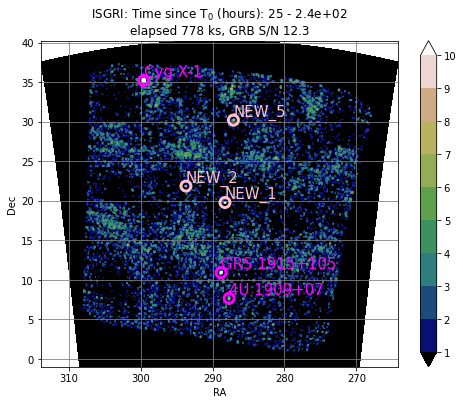

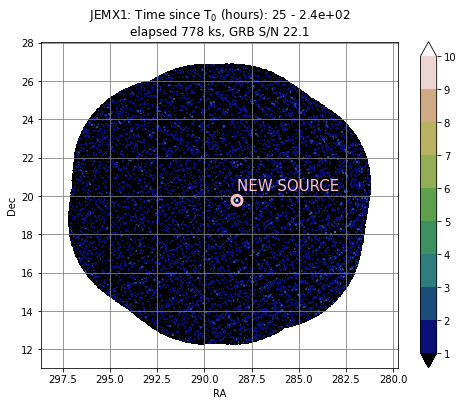

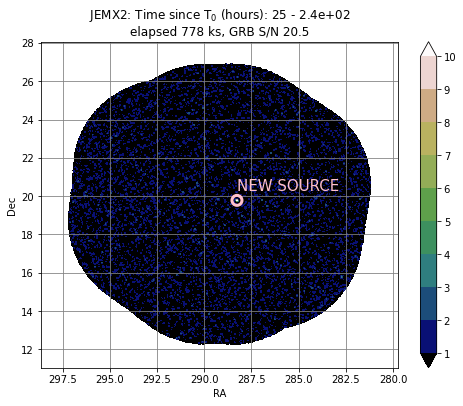

In [12]:
for name, image in source_images.items():
    if image:
        h = image.mosaic_image_0_mosaic.data_unit[4].header
        t = image.dispatcher_catalog_1.table        
        m = SkyCoord(t['ra'], t['dec']).separation(src_coord).arcmin <10

        try:
            snr = t[m]['significance'][0]
        except:
            snr = 0

        t = Time(h['TSTART'] + 51544, format='mjd').isot
        (im:=oda_api.plot_tools.OdaImage(image)).show(sliders=False)
        im.write_fits(f'{name}_{focus_obs_name}_')
        plt.title(f"{name.upper()}: Time since T$_0$ (hours): {(h['TSTART'] - T0_ijd)*24:.2g} - {(h['TSTOP'] - T0_ijd)*24:.2g}\n"
                  f"elapsed {int(h['TSTOP'] - h['TSTART'])*24*3.6:.3g} ks, GRB S/N {snr:.3g}")

In [13]:
# ! pip install pymosaic-fits
import mosaic
import importlib
importlib.reload(mosaic)
mosa = mosaic.FITsMosaic()

from astropy.io import fits

for ins in 'jemx1', 'jemx2': #, 'isgri':
    f = fits.open(f"{ins}_r2560_mosaic.fits")

    new_hdus = [fits.PrimaryHDU()]

    for i in f[2:-1]:

        for k, v in dict(i.header).items():
            if str(v).strip() == 'Real':
                print('patching', k)
                i.header[k] = 1000

        if i.header.get('IMATYPE', '') == 'RECONSTRUCTED':
            i.header['IMATYPE'] = 'INTENSITY'

        i.header['TELAPSE'] = 1000
        i.header['TFIRST'] = 0
        i.header['TLAST'] = 1000
        i.header['E_MIN'] = 3.04
        i.header['E_MAX'] = 29.84
        print(i.header.get('IMATYPE', '??'))
        new_hdus.append(i)
        
        
    fits.HDUList(new_hdus).writeto(f"{ins}_r2560_mosaic_mod.fits", overwrite=True)
    mosa.add(fits.open(f"{ins}_r2560_mosaic_mod.fits"))

mosa.writeto('jemxX_mosaic.fits')


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.
INFO:root:first mosaic
INFO:root:adding mosaic


patching TELAPSE
INTENSITY
patching TELAPSE
VARIANCE
patching TELAPSE
SIGNIFICANCE
patching TELAPSE
EXPOSURE
patching TELAPSE
INTENSITY
patching TELAPSE
VARIANCE
patching TELAPSE
SIGNIFICANCE
patching TELAPSE
EXPOSURE


In [14]:
cat = source_images['isgri'].dispatcher_catalog_1

toremove = []
for i, r in enumerate(cat.table.iterrows()):
    print(r)
    if r[1].startswith('NEW_') or r[1].startswith('GRB') or r[1].startswith('SGR'):
        toremove.append(i)        

cat.table.add_row(
{
    'src_names': source_name,
    'ra': src_coord.ra.deg,
    'dec': src_coord.dec.deg,
    # 'ISGRI_FLAG': 1,
    'FLAG': 1,
    'ERR_RAD': 0.05,    
})

sgr = SkyCoord.from_name('SGR 1935+2154')
cat.table.add_row(
{
    'src_names': 'SGR 1935+2154',
    'ra': sgr.ra.deg,
    'dec': sgr.dec.deg,
    # 'ISGRI_FLAG': 1,
    'FLAG': 1,
    'ERR_RAD': 0.05,    
})


cat.table.remove_rows(toremove)

cat.table

(6, '4U 1909+07', 7.601008892059326, 287.69488525390625, 7.671874046325684, -32768, 1, 0, 0.006670000031590462)
(9, 'Cyg X-1', 173.6497039794922, 299.5948181152344, 35.20621109008789, -32768, 2, 0, 0.0002800000074785203)
(10, 'GRS 1915+105', 18.443647384643555, 288.8116760253906, 10.92329216003418, -32768, 2, 0, 0.0002800000074785203)
(81, 'NEW_1', 12.31788444519043, 288.2734680175781, 19.78383445739746, -32767, 0, 0, None)
(82, 'NEW_2', 9.223123550415039, 293.704833984375, 21.861047744750977, -32767, 0, 0, None)
(85, 'NEW_5', 7.817286491394043, 287.0945739746094, 30.20005989074707, -32767, 0, 0, None)


meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str13,float64,float64,float64,int64,int64,int64,object
6,4U 1909+07,7.601008892059326,287.69488525390625,7.671874046325684,-32768,1,0,0.006670000031590462
9,Cyg X-1,173.6497039794922,299.5948181152344,35.20621109008789,-32768,2,0,0.0002800000074785203
10,GRS 1915+105,18.443647384643555,288.8116760253906,10.92329216003418,-32768,2,0,0.0002800000074785203
0,GRB221009A,0.0,288.26429166666657,19.773083333333332,0,0,1,0.05
0,SGR 1935+2154,0.0,293.732,21.896722,0,0,1,0.05


In [15]:
from astropy.table import Table

m_source = [not s.startswith('NEW') for s in cat.table['src_names']]
cat.table = Table(cat.table[m_source])

cat.get_api_dictionary()

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[6, 9, 10, 0, 0], ["4U 1909+07", "Cyg X-1", "GRS 1915+105", "GRB221009A", "SGR 1935+2154"], [7.601008892059326, 173.6497039794922, 18.443647384643555, 0.0, 0.0], [287.69488525390625, 299.5948181152344, 288.8116760253906, 288.26429166666657, 293.732], [7.671874046325684, 35.20621109008789, 10.92329216003418, 19.773083333333332, 21.896722], [-32768, -32768, -32768, 0, 0], [1, 2, 2, 0, 0], [0, 0, 0, 1, 1], [0.006670000031590462, 0.0002800000074785203, 0.0002800000074785203, 0.05, 0.05]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U13"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "|O"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}'

In [16]:

# from ddpaper.draftdata import DraftData

with obs_draft_data as dd:
    dd['obs'] = dict(
    )


/home/savchenk/.local/lib/python3.8/site-packages/ddpaper/draftdata.py:20: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  self.data = yaml.load(


In [17]:
source_products = {}

for product in [
        "isgri_lc",
        "isgri_spectrum",
        "isgri_image",
        "isgrihe_image",
        "jemx1_lc",
        "jemx1_spectrum",
        "jemx1_image",
        "jemx2_lc",
        "jemx2_spectrum",
        "jemx2_image",
    ]:
    disp.wait = False
    
    if 'jemx' in product:
        e1, e2 = 4, 30
    else:
        e1, e2 = 28, 80
    
    jnum = 1
    product_pass = product

    if 'jemx1' in product:
        jnum=1
        product_pass = product.replace("jemx1_", "jemx_")
    elif 'jemx2' in product:
        jnum=2
        product_pass = product.replace("jemx2_", "jemx_")
    elif 'isgrihe' in product:
        e1, e2 = 80, 200
        product_pass = product.replace("isgrihe_", "isgri_")
    
    source_products[product] = disp.get_product(
        instrument=product_pass.split("_")[0],
        product=product_pass,
        osa_version="OSA11.2",
        scw_list=[s+".000" for s in scw_list],
        token = oda_api.token.discover_token(),
        E1_keV=e1,
        E2_keV=e2,
        jemx_num=jnum,
        selected_catalog=cat.get_api_dictionary(),
        integral_data_rights="all-private",
    )

found token in file in home your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1667045307,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}
INFO:oda_api.token:found token in file in home your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1667045307,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}
token expires in 93.6 h
INFO:oda_api.token:token expires in 93.6 h
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbos

In [18]:
source_products

{'isgri_lc': <oda_api.api.DataCollection at 0x7ff6062bd700>,
 'isgri_spectrum': <oda_api.api.DataCollection at 0x7ff6065ebd60>,
 'isgri_image': <oda_api.api.DataCollection at 0x7ff5e6fec610>,
 'isgrihe_image': <oda_api.api.DataCollection at 0x7ff5e6ae1490>,
 'jemx1_lc': <oda_api.api.DataCollection at 0x7ff5e5683a60>,
 'jemx1_spectrum': <oda_api.api.DataCollection at 0x7ff605f43760>,
 'jemx1_image': <oda_api.api.DataCollection at 0x7ff5e5583970>,
 'jemx2_lc': <oda_api.api.DataCollection at 0x7ff5e5994ca0>,
 'jemx2_spectrum': <oda_api.api.DataCollection at 0x7ff5e5583ac0>,
 'jemx2_image': <oda_api.api.DataCollection at 0x7ff5e55fb6a0>}

In [19]:
d = source_products['isgrihe_image']
d.dispatcher_catalog_1.get_api_dictionary()

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[1, 3, 4, 5, 10], ["Cyg X-1", "NEW_1", "NEW_2", "NEW_3", "NEW_8"], [45.55516052246094, 7.8420867919921875, 7.339420318603516, 7.340843677520752, 7.487318515777588], [299.59564208984375, 279.2430725097656, 276.4566650390625, 278.969482421875, 282.5522766113281], [35.19932174682617, 4.531042098999023, 6.836004734039307, 5.209732532501221, 20.5789794921875], [-32768, -32767, -32767, -32767, -32767], [2, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0.0, null, null, null, null]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U7"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "|O"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}'

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.
/home/savchenk/.local/lib/python3.8/site-packages/oda_api/plot_tools.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/home/savchenk/.local/lib/python3.8/site-packages/ddpaper/draftdata.py:20: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarni

no GRB here!
no GRB here!


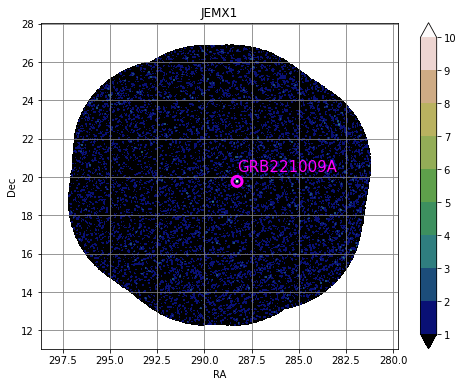

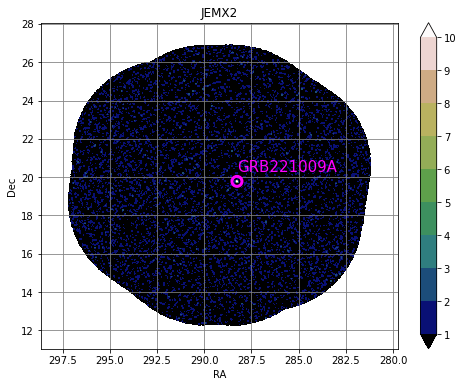

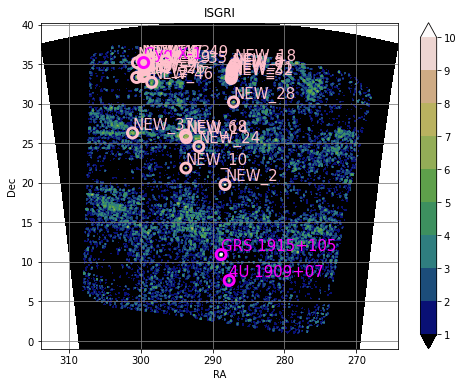

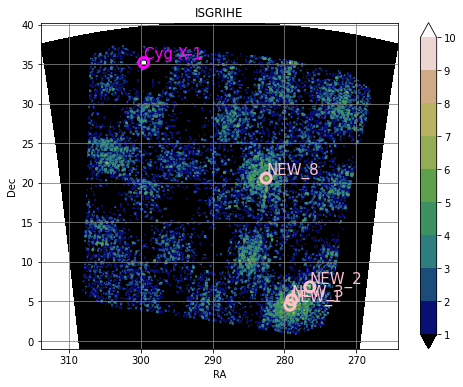

In [20]:
for instrument in 'jemx1', 'jemx2', 'isgri', 'isgrihe':
    p = source_products[instrument + '_image']
    oda_api.plot_tools.OdaImage(p).show(sliders=False) #, header="JEM-X")
    oda_api.plot_tools.OdaImage(p).write_fits(instrument + "_")
    plt.title(instrument.upper())
    plt.savefig(f"figs/{instrument}.png")

    with obs_draft_data as dd:
        try:
            dd[instrument] = {'snr': float(p.dispatcher_catalog_1.table[p.dispatcher_catalog_1.table['src_names'] == "GRB221009A"]['significance'][0])}
        except IndexError:
            print("no GRB here!")
        


/home/savchenk/.local/lib/python3.8/site-packages/oda_api/plot_tools.py:450: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


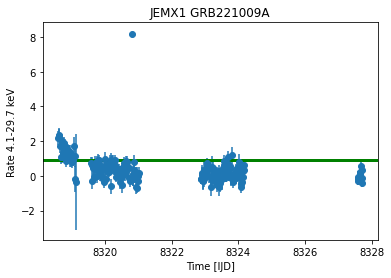

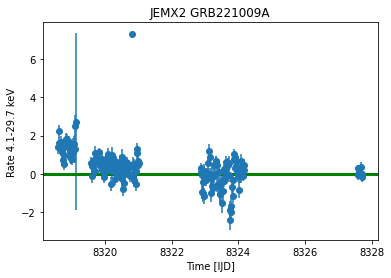

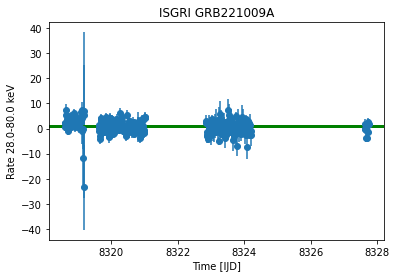

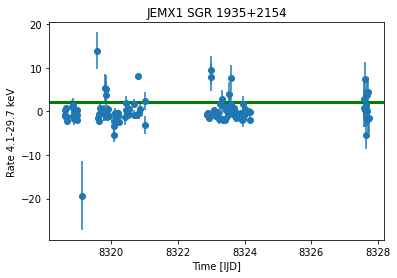

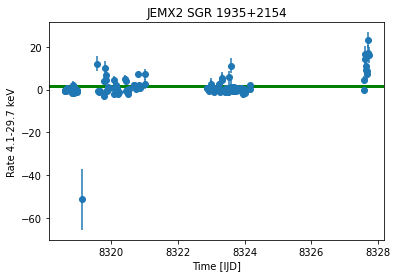

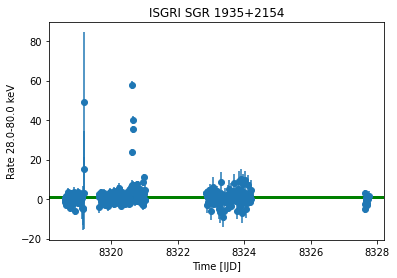

In [21]:
import re

for name in 'GRB221009A', 'SGR 1935+2154':
    name_stub = re.sub("[^0-9a-zA-Z]", "", name).lower()

    for instrument in 'jemx1', 'jemx2', 'isgri':
        oda_api.plot_tools.OdaLightCurve(source_products[instrument + '_lc']).show(in_source_name=name)
        oda_api.plot_tools.OdaLightCurve(source_products[instrument + '_lc']).write_fits(name)
        plt.title(instrument.upper() + " " + name)
        plt.savefig(f"figs/lc_{instrument}_{name_stub}.png")


In [22]:
for instrument in 'jemx1', 'jemx2', 'isgri':
    p = source_products[instrument + '_spectrum']
    oda_api.plot_tools.OdaSpectrum(source_products[instrument + '_spectrum']).write_fits('GRB221009A')
    
    spec = getattr(p, [l['prod_name'] for l in p.as_list() if l['meta_data:']['src_name'] == 'GRB221009A'][0])
    
    with obs_draft_data as dd:
        if instrument not in dd:
            dd[instrument] = {}
        dd[instrument]['exposure_s'] = spec.data_unit[1].header['EXPOSURE']

Saving spectrum ./JMX1_spectrum_GRB221009A.fits with rmf ./JMX1_rmf_GRB221009A.fits and arf ./JMX1_arf_GRB221009A.fits
INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./JMX1_spectrum_GRB221009A.fits with rmf ./JMX1_rmf_GRB221009A.fits and arf ./JMX1_arf_GRB221009A.fits
Saving spectrum ./JMX2_spectrum_GRB221009A.fits with rmf ./JMX2_rmf_GRB221009A.fits and arf ./JMX2_arf_GRB221009A.fits
INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./JMX2_spectrum_GRB221009A.fits with rmf ./JMX2_rmf_GRB221009A.fits and arf ./JMX2_arf_GRB221009A.fits
Saving spectrum ./IBIS_spectrum_GRB221009A.fits with rmf ./IBIS_rmf_GRB221009A.fits and arf ./IBIS_arf_GRB221009A.fits
INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./IBIS_spectrum_GRB221009A.fits with rmf ./IBIS_rmf_GRB221009A.fits and arf ./IBIS_arf_GRB221009A.fits


In [23]:
with obs_draft_data as dd:
    dd['joint_fit'] = dict(
        e1_keV=3,
        e2_keV=80,
        flux_ecs = 4.4263e-10, # ergs/cm^2/s) range (3.0000 - 80.000 keV
        flux_ecs_err_68p = (4.215e-10 - 4.4263e-10, 4.670e-10 - 4.4263e-10),
        slope = 2.15041,
        slope_err_90p = (-0.0712388,0.0841283)
    )

In [32]:
acslc_r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/{T0_ijd}/10000")
import pandas as pd
import io

acslc = pd.read_csv(io.StringIO(acslc_r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)
acslc

,t,dt,c,ds
0,8317.437732,0.029810,5296.0,37750.845810
1,8317.437732,0.079809,5170.0,37750.895809
2,8317.437733,0.129811,5144.0,37750.945811
3,8317.437734,0.179810,5234.0,37750.995810
4,8317.437734,0.229809,5292.0,37751.045809
...,...,...,...,...
399995,8317.669211,19999.793240,5294.0,57750.609241
399996,8317.669211,19999.843240,5352.0,57750.659240
399997,8317.669212,19999.893240,5336.0,57750.709243
399998,8317.669212,19999.943240,5302.0,57750.759242


In [33]:
bkg = np.mean(acslc.c[acslc.t<T0_ijd - 1000./24/3600])


def rebin(x, n):
    N = int(len(x)/n)
    return np.array(x[:N*n]).reshape((N, n)).sum(1)


from scipy.optimize import curve_fit

F = lambda x,a,b,c,d: a+b*x+c*x**2+d*x**3
n = 1000
T = (rebin(acslc.t, n)/n - T0_ijd)*24
m = T < -1
m |= T > 3

curve = curve_fit(
    F,
    T[m],
    (rebin(acslc.c, n)/n - bkg)[m]
    )


curve

(array([ 1.8718861 , 23.81116769, 21.70265544,  4.63758302]),
 array([[213.29578321, 364.30038276, 197.2597053 ,  34.11920994],
        [364.30038276, 628.12865696, 342.91554164,  59.72419572],
        [197.2597053 , 342.91554164, 188.66035669,  33.08381934],
        [ 34.11920994,  59.72419572,  33.08381934,   5.83832632]]))

In [31]:
F

<function __main__.<lambda>(x, a, b, c, d)>

Text(0.5, 0, 'hours since 2022-10-09T13:17:00')

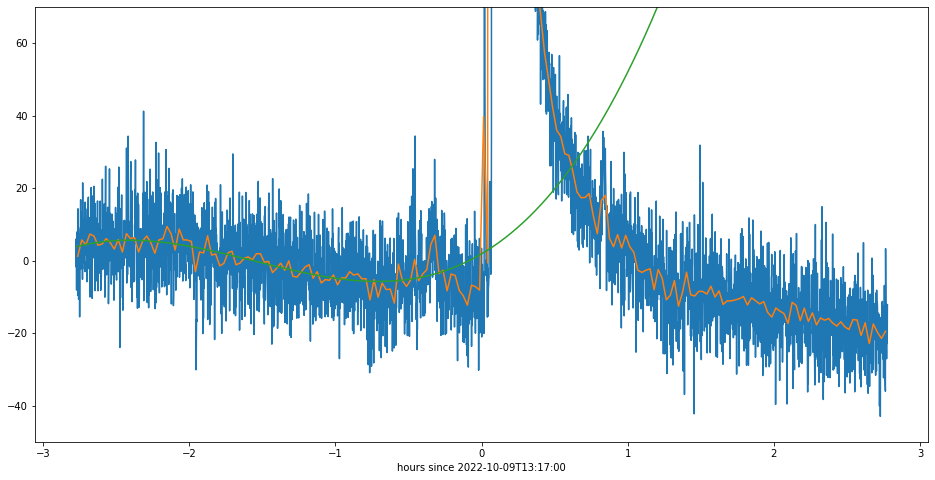

In [34]:
plt.figure(figsize=(16,8))


for n in 100, 2000:

    plt.plot(
        (rebin(acslc.t, n)/n - T0_ijd)*24,
        rebin(acslc.c, n)/n - bkg, # - F((rebin(acslc.t, n)/n - T0_ijd)*24, *curve[0])
    )

# plt.plot(
#     T[m],
#     (rebin(acslc.c, n)/n - bkg)[m]
# )

plt.plot(
    T,
    F(T, *curve[0])
)

plt.ylim([-50,70])

plt.xlabel(f'hours since {T0_isot}')

In [ ]:
T0bat = Time('2022-10-09 14:10:17')


def xrt_decay(t):
    # #32671
    offset_s = ((T0bat.mjd - 51544) - T0_ijd)*24*3600
    slopes = """Alpha_1 : 2.6 (+0.4, -0.7)
    Tbreak_1: 177.4 (+2.0, -9.6)
    Alpha_2 : 0.144 (+0.022, -0.026)
    Tbreak_2: 610 (+84, -78)
    Alpha_3 : 0.31 (+0.04, -0.03)
    Tbreak_3: 4060 [+0.23, -0.19])
    Alpha_4 : 1.357 (+/-0.010)"""

    slopes =  {s.split(":")[0].strip(): float(s.split(":")[1].split()[0].strip()) for s in slopes.split("\n")}

    for k in slopes:
        if k.startswith('Tbr'):
            slopes[k] += offset_s

    r = t**(-slopes['Alpha_1'])

    m = t > slopes['Tbreak_1'] 
    rn1 = slopes['Tbreak_1']**(-slopes['Alpha_1']) / slopes['Tbreak_1']**(-slopes['Alpha_2'])
    r[m] = t[m]**(-slopes['Alpha_2']) * rn1

    m = t > slopes['Tbreak_2']
    rn2 = slopes['Tbreak_2']**(-slopes['Alpha_2']) / slopes['Tbreak_2']**(-slopes['Alpha_3']) 
    r[m] = t[m]**(-slopes['Alpha_3']) * rn1 * rn2


    m = t > slopes['Tbreak_3']
    rn3 = slopes['Tbreak_3']**(-slopes['Alpha_3']) / slopes['Tbreak_3']**(-slopes['Alpha_4']) 
    r[m] = t[m]**(-slopes['Alpha_4']) * rn1 * rn2 * rn3
    
    return r


t = np.logspace(0,4)

plt.figure()

plt.plot(
    t,
    xrt_decay(t)
)

plt.loglog()


In [ ]:
plt.figure()

d = d_j2
plt.errorbar(d['TIME'] - T0_ijd, d['RATE'],d['ERROR'])

m = d['TIME'] < 8319.5

# plt.errorbar(
#     np.mean(d['TIME'][m]) - T0_ijd, 
#     np.sum(d['RATE'][m])/np.sum(m),
#     (np.sum(d['ERROR'][m]**2)**0.5/np.sum(m)), lw=3)

T = np.logspace(-1, 1, 60)
Tc = (T[1:] + T[:-1])/2.
dT = (T[1:] - T[:-1])/2.

plt.errorbar(
    Tc, 
    rebin_in_bins(d['TIME'] - T0_ijd, d['RATE'], T),
    rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x)),
    xerr=dT,
    ls="",
     lw=3)


plt.xlim([1,2])
# plt.ylim([0,5])

In [ ]:
def rebin_in_bins(t, x, T, agg=np.mean):
    # i =
    X = []
    for _t1, _t2 in zip(T[:-1], T[1:]):
        m = (t > _t1) & (t <= _t2)
        X.append(agg(x[m]))

    return np.array(X)


def rebin_bins_in_bins(t, dt, x, dx, Tb):
    T = []
    dT = []
    X = []
    dX = []    
    for _t1, _t2 in zip(Tb[:-1], Tb[1:]):        
        m = (t > _t1) & (t <= _t2)
        if np.sum(m) > 0:
            T.append((np.max(t[m] + dt[m]) + np.min(t[m] - dt[m]))/2)
            dT.append((np.max(t[m] + dt[m]) - np.min(t[m] - dt[m]))/2)
            X.append(np.sum(x[m]*dt[m])/dT[-1])
            dX.append(
                np.sum((dx[m]*dt[m])**2)**0.5/dT[-1]
                )

    return np.array(T), np.array(dT), np.array(X), np.array(dX)

rebinned_lc_by_name = {}


for t, dt, r, re, f, n, T in [
    # (d_j1['TIME'], d_j1['TIMEDEL']/2, (d_j1['RATE'] + d_j2['RATE'])/2, (d_j1['ERROR']**2 + d_j1['ERROR']**2)**0.5/2, 1, 'JEMX1+2', np.logspace(-0.2, 1, 35)),
    # (d_j1['TIME'], d_j1['TIMEDEL']/2, d_j1['RATE'], d_j1['ERROR'], 1, 'JEMX1', np.logspace(-1, 1, 10000)),
    (d_j1['TIME'], d_j1['TIMEDEL']/2, d_j1['RATE'], d_j1['ERROR'], 1, 'JEMX1', np.logspace(-0.1, 1, 4)),
    # (d_j2['TIME'], d_j2['TIMEDEL']/2, d_j2['RATE'], d_j2['ERROR'], 1, 'JEMX2', np.logspace(-0.3, 1, 40)),
    (d_i['TIME'], d_i['TIMEDEL'],d_i['RATE'], d_i['ERROR'], 0.01, 'ISGRI', np.logspace(-0.1, 1, 4)),
]:    
    m = r < 6 # noisy scw?
    m &= re < 4 # noisy scw?
    t = t - T0_ijd

    plt.errorbar(t[m], r[m], re[m], xerr=dt[m], alpha=0.5, ls="")

    Tc, dT, X, dX = rebin_bins_in_bins(t[m], dt[m], r[m], re[m], T)

    
    # plt.errorbar(t, r,re,         # xerr=d['TIMEDEL']/2, 
    #     ls="", label=n, alpha=0.2)

    plt.errorbar(
        Tc,
        X,
        dX,
        # rebin_in_bins(t, re, T, agg=lambda x:(np.sum(x**2))**0.5/len(x)),
        xerr=dT,
        ls="", 
        label=n)

    rebinned_lc_by_name[n] = {
        'Tc': Tc,
        'X': X,
        'dX': dX,
        'dT': dT,
    }


# plt.semilogx()
plt.loglog()
# plt.xlim([5e-1, 12])
# plt.xlim([0.8, 1.5])
# plt.ylim([-5, 10])

# rebin_in_bins(t, r, T, agg=np.mean)

In [ ]:
rmax = d_j1[d_j1['RATE'].argmax()]
rmax['TIME']

plt.errorbar(
    d_j2['TIME'] - rmax['TIME'],
    d_j2['RATE'],
    d_j2['ERROR']
)

plt.xlim([-0.2, 0.2])

requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/converttime/IJD/{rmax['TIME']}/SCWID").json()

In [ ]:
from scipy.interpolate import interp1d
CS = np.cumsum(np.array(acslc.c) - bkg)
interp1d(CS, acslc.t)(np.linspace(0, CS[-1], int(CS[-1]/1000))).shape

In [ ]:
from statistics import mode


plt.figure(figsize=(8,4))

# n = 500
# c = plt.errorbar(
#         (rebin(acslc.t[m], n)/n - T0_ijd),
#         (rebin(acslc.c[m], n)/n - bkg - F((rebin(acslc.t[m], n)/n - T0_ijd)*24, *curve[0]))/acs_scale,
#         # (rebin(acslc.c, n)/n - bkg - F((rebin(acslc.t, n)/n - T0_ijd)*24, *curve[0]))
#         (rebin(acslc.c[m], n))**0.5/n/acs_scale
#     )[0].get_color()

plt.plot(
    (acslc.t - T0_ijd)*24*3600,
    acslc.c,
    # acslc
)

plt.xlabel(f"days since {T0_isot}")

# plt.axvspan(Time("2022-10-10 13:27:56").mjd - 51544 - T0_ijd, Time("2022-10-10 14:27:28").mjd - 51544 - T0_ijd, alpha=0.2)
# plt.axvspan(Time("2022-10-10 15:02:00").mjd - 51544 - T0_ijd, Time("2022-10-11 04:19:48").mjd - 51544 - T0_ijd, alpha=0.2)


if False:
    from scipy.optimize import minimize

    # minimize()l
    t_model = lambda t, N, slope: N*t**slope
    slope = -1.3
    t_model_noslope = lambda t, N: N*t**slope_0

    def loss(p):
        if len(p) == 1:
            N, = p
            slope = -1.3
        else:
            N, slope = p
            
        d = np.concatenate([
            (t_model(d_j1['TIME'] - T0_ijd, N, slope) - d_j1['RATE']) / d_j1['ERROR'],
            (t_model(d_j2['TIME'] - T0_ijd, N, slope) - d_j2['RATE']) / d_j2['ERROR']
        ])
        

        m = d**2 < np.percentile(d**2, 95)

        # print(N, slope, (d**2).sum(), d_j1[d.argmax()], d_j1[d.argmin()])
        # plt.plot(d_j1['TIME'], d**2)
        return np.sum(d[m]**2) # + \
            #    np.sum(((t_model(d_j2['TIME'] - T0_ijd, N, slope) - d_j2['RATE']) / d_j2['ERROR'])**2) + \
            #    np.sum(((t_model(d_i['TIME'] - T0_ijd, N, slope) - d_i['RATE']) / d_i['ERROR'])**2)

    slope_fitted = slope
    N_fitted, = minimize(loss, [1]).x
    # N_fitted, slope_fitted = minimize(loss, [N_fitted, slope]).x


    t = np.logspace(-1.5, 1, 100) + 200
    plt.plot(t, t_model(t, N_fitted, slope_fitted), ls="--", label=f'fit to JEM-X and ISGRI light curves, slope={slope_fitted:.3g}, N={N_fitted:.2g}')


xrt_norm = 1e3

# t = np.logspace(np.log10(T0bat.mjd - 51544 - T0_ijd), 1, 100)  
# plt.plot(t, xrt_norm*xrt_decay(t*24*3600)*1e8, label="XRT decay", lw=3, ls="-", c='k', alpha=0.5)

plt.legend()

plt.xlim([0, 800])
# plt.ylim([1e-2, 3e6])

# plt.xlim([-0., 0.5])
# plt.ylim([-300, 300])


# ax_x_hours = plt.twiny()

# plt.ylabel("erg cm$^{-2}$ s$^{-1}$")
plt.ylabel("counts s$^{-1}$")
plt.savefig("figs/joint_lc.png")
plt.savefig("grb221009-picture/spiacs-lc.png")

# https://www.swift.ac.uk/burst_analyser/01126853/
# https://gcn.gsfc.nasa.gov/gcn3/32671.gcn3

In [ ]:
from IPython.display import Image

Image('jemx-p3.png')

In [ ]:
with obs_draft_data as dd:
    dd['T0_isot'] = T0_isot
    dd['tstart_isot'] = Time(d_j1['TIME'].min()+51544, format='mjd').isot
    dd['tstart_since_t0'] = d_j1['TIME'].min() - T0_ijd
    dd['tstop_isot'] = Time(d_j1['TIME'].max()+51544, format='mjd').isot
    dd['tstop_since_t0'] = d_j1['TIME'].max() - T0_ijd
    dd['ontime_s'] = np.sum(d_j1['TIMEDEL'])*24*3600

In [ ]:
with obs_draft_data as dd:
    dd['scheduled_obs'] = {
        'T1_isot': '2022-10-11 13:52:21',
        'T2_isot': '2022-10-13 00:58:26'
    }
    dd['scheduled_obs_p3'] = {
        'T1_isot': '2022-10-14 20:42:27',
        'T2_isot': '2022-10-16 04:47:41',
        'ref': 'https://www.cosmos.esa.int/web/integral/schedule-information'
    }

    dd['ixpe_obs'] = {
        'T1_isot': '2022-10-11T23:34:28',
        'T2_isot': '2022-10-14T00:45:31',
        'ref': 'https://www.astronomerstelegram.org/?read=15678' 
    }

In [ ]:
!curl https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/converttime/UTC/2022-10-09T13:17:00/SCWID

In [ ]:
with DraftData() as dd:
    dd['sc'] = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/scsystem/api/v1.0/sc/{T0_isot}/{src_coord.ra.deg}/{src_coord.dec.deg}").json()

In [ ]:
from astropy.io import fits

# compton_events = fits.open("/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/2558/255800290010.000/compton_events.fits.gz")
# compton_events1 = fits.open("/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/2558/255800300021.000////compton_events.fits.gz")
# compton_events2 = fits.open("/mnt/sshfs/cdcihn/isdc/pvphase/nrt/ops/scw/2558/255800300010.000///compton_events.fits.gz")


In [ ]:
mce = dict()

for i in range(8):
    mce[i] = pd.read_csv(
        io.StringIO(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/genlc/ISGRIRAW_MCE{i}/{T0_ijd}/2000").text), 
        skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)


np.sum([mce[i].c for i in range(8)], axis=0)

In [ ]:
# plt.figure(figsize=(16, 6))

# for color, ext in ('g', "COMP-MULE-ALL"), ('r', 'COMP-SGLE-ALL'):
#     label=ext
    
#     for c in compton_events, compton_events1, compton_events2:
#         T = c[ext].data['TIME']
#         E = c[ext].data['ISGRI_ENERGY']

#         plt.hist((T - T0_ijd)*24*3600, bins=1000, alpha=0.3, color=color, label=label)
#         label = None
    
# # for i in range(8):
# plt.plot((mce[0].t- T0_ijd)*24*3600, np.sum([mce[i].c for i in range(8)], axis=0 )/20, label="ISGRI RAW rate")

# plt.legend()
# plt.xlabel(f"seconds since {T0_isot}")
# plt.xlim([0, 1000])

In [ ]:
mce[0].t[:10], mce[2].t[:10]